# 深度循环神经网络 Deep RNN

在简单RNN/LSTM中，单隐藏层结构已能处理许多序列任务，但随着任务复杂度提升（如视频理解、文档摘要），其缺陷日益显著：

- 特征抽象不足：单层隐藏状态需同时编码低级语法（如词性）和高级语义（如情感倾向），导致信息过载。

- 长程依赖衰减：即便LSTM有门控机制，超长序列中关键信息仍可能在多层时间传递后稀释。

- 模式识别单一：时序动态与空间特征的联合建模能力有限（如无法同时捕捉视频中的动作和物体）。

*单层记忆结构如同试图用一台收音机同时接收所有频道——信号混杂，难以分辨。*

深度RNN的核心思想：层次化时序特征

- 底层：捕捉局部模式（如单词/帧级别的变化）。

- 中层：组合局部模式为片段语义（如句子/动作片段）。

- 高层：建模全局依赖（如段落/视频主题）。

下面是一个简单的深度循环神经网络

In [1]:
import torch

# 在 torch.nn.RNN 里面可以设定 num_layers 来设置层数，如果层数 > 1 返回的模型就是深度循环神经网络
# 来测试一下输出
num_layers = 3

model = torch.nn.RNN(input_size=32, hidden_size=64, num_layers=num_layers, dropout=0.1, batch_first=True)

inputs = torch.randn(100, 20, 32)
hidden = torch.zeros(num_layers, 100, 64)

outputs, hidden = model(inputs, hidden)

# RNN 返回的是输出和每一层的隐藏状态
print(outputs.shape)
print(hidden.shape)

torch.Size([100, 20, 64])
torch.Size([3, 100, 64])


In [2]:
# 长短期记忆 torch.nn.LSTM 作为一种 RNN 也可以也设定 num_layers > 1 来实现深度循环神经网络

model = torch.nn.LSTM(input_size=32, hidden_size=64, num_layers=num_layers, dropout=0.1, batch_first=True)

inputs = torch.randn(100, 20, 32)
hidden = torch.zeros(num_layers, 100, 64)

outputs, (hidden, cell) = model(inputs)

# 和传统 RNN 不同的是，深度长短期记忆返回的是输出和每一层的隐藏状态与细胞状态

print(outputs.shape)
print(hidden.shape)
print(cell.shape)

torch.Size([100, 20, 64])
torch.Size([3, 100, 64])
torch.Size([3, 100, 64])


In [3]:
# 下面我们将手动实现一个深度循环神经网络

class RNN(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor):
        outputs = []
        for i in inputs.unbind(1):
            combined = torch.cat([i, hidden], dim=-1)
            hidden = torch.tanh(self.i2h(combined))
            outputs.append(hidden)
        return torch.stack(outputs, dim=1), hidden


class DeepRNNCell(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, dropout: float | None = None):
        super().__init__()
        self.rnn = RNN(input_size, hidden_size)
        self.norm = torch.nn.LayerNorm(hidden_size)
        self.dropout = torch.nn.Dropout(dropout) if dropout and dropout > 0 else None

    def forward(self, inputs: torch.Tensor, hidden: torch.Tensor):
        outputs, hidden = self.rnn(inputs, hidden)
        outputs = self.norm(outputs)
        if self.dropout is not None:
            outputs = self.dropout(outputs)
        return outputs, hidden


class DeepRNN(torch.nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, dropout: float | None = None):
        assert num_layers > 1
        super().__init__()
        self.layers = torch.nn.ModuleList([DeepRNNCell(input_size, hidden_size, dropout)])
        for _ in range(num_layers - 2):
            self.layers.append(DeepRNNCell(hidden_size, hidden_size, dropout))
        # dropout 是概率随机丢失参数，层间加入 dropout 为了防止过拟合。最后一层不加 dropout 增加输出稳定性
        self.layers.append(DeepRNNCell(hidden_size, hidden_size))

    def forward(self, inputs: torch.Tensor, input_hiddens: torch.Tensor):
        outputs = inputs
        output_hiddens = []
        for i, cell in enumerate(self.layers):
            outputs, hidden = cell(outputs, input_hiddens[i])
            output_hiddens.append(hidden)
        return outputs, torch.stack(output_hiddens, dim=0)

In [4]:
model = DeepRNN(input_size=32, hidden_size=64, num_layers=3, dropout=0.1)

inputs = torch.randn(100, 20, 32)
hidden = torch.zeros(num_layers, 100, 64)

outputs, hidden = model(inputs, hidden)

print(outputs.shape)
print(hidden.shape)

torch.Size([100, 20, 64])
torch.Size([3, 100, 64])


# 大语言模型的雏形

我们将用上面的模型训练一个~并不~大语言模型。

语言模型的第一步是词嵌入 Embedding 它的作用是使词转换成张量以方便模型处理

假如我们使用分词器解码 `"蛙鼠战争"` 得到了编码 `[1,2,3]`

为了将词编码转换成词向量，我们很容易就想到了下面的编码方式

```
"蛙" → [1, 0, 0]
"鼠" → [0, 1, 0]
"战争" → [0, 0, 1]
```

这种方法是**独热编码 One-Hot Encoding**，简单且易实现。

但是问题也很明显:

维度灾难	词表增长导致向量维度爆炸，每个词都是一个维度。

语义盲区	所有词向量正交，无法表达相似性。"蛙"与"鼠"的距离和"蛙"与"战争"的距离相同。

但是，独热编码确实成功的将词编码转换成词向量。为了避免维度灾难，我们可以将词向量通过线性层转换成低维度的向量。

这个就是目前通用的词嵌入。

*关于词向量的讨论在本项目代码库里实现，此处不进行展开。*

接下来会实现一个语言模型，模型里隐含了词向量的转换。

In [5]:
from datasets import load_dataset
from tokenizers import Tokenizer, models, trainers

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = load_dataset("code_search_net", "python")["train"].filter(lambda x: "apache/spark" in x["repository_name"])["func_code_string"]

dataset.sort(key=lambda x: len(x))

In [6]:
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
tokenizer = Tokenizer(models.WordPiece(unk_token="[UNK]"))
trainer = trainers.WordPieceTrainer(
    vocab_size=1000,
    min_frequency=10,
    special_tokens=special_tokens + [".", ",", "!", "?", ";", ":"],
)
tokenizer.train_from_iterator(dataset, trainer=trainer)

In [7]:
class ChatDeepRNN(torch.nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        emb_size: int,
        hidden_size: int,
        num_layers: int,
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vocab_size = self.tokenizer.get_vocab_size()
        self.bos_ind = self.tokenizer.token_to_id("[BOS]")
        self.pad_ind = self.tokenizer.token_to_id("[PAD]")
        self.eos_ind = self.tokenizer.token_to_id("[EOS]")
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # 模型本体
        self.emb = torch.nn.Embedding(self.vocab_size, emb_size)
        self.deep_rnn = DeepRNN(emb_size, hidden_size, num_layers, 0.1)
        self.lm = torch.nn.Linear(hidden_size, self.vocab_size)

    def forward(self, inputs: torch.Tensor, hiddens: torch.Tensor):
        embeddings = self.emb(inputs)
        outputs, hiddens = self.deep_rnn(embeddings, hiddens)
        return self.lm(outputs), hiddens

    @torch.no_grad()
    def generate(self, context: str, max_new_tokens: int = 512, device=DEVICE):
        context_tensor = torch.tensor([self.bos_ind] + tokenizer.encode(context).ids, dtype=torch.long, device=device).unsqueeze(0)
        hiddens = torch.zeros((self.num_layers, 1, self.hidden_size), device=device)
        logits, hiddens = self(context_tensor, hiddens)
        probs = torch.softmax(logits.squeeze(0)[-1], dim=-1)
        idx = torch.multinomial(probs, num_samples=1)
        outs = context_tensor.squeeze(0).tolist()
        outs.append(idx.item())
        for _ in range(max_new_tokens):
            logits, hiddens = self(idx.unsqueeze(0), hiddens)
            probs = torch.softmax(logits.squeeze(0)[-1], dim=-1)
            idx = torch.multinomial(probs, num_samples=1)
            xi = idx.item()
            if xi == self.bos_ind:
                continue
            if xi == self.pad_ind:
                continue
            if xi == self.eos_ind:
                break
            outs.append(idx)
        return self.tokenizer.decode(outs, skip_special_tokens=False).replace(" ##", "")

In [8]:
model = ChatDeepRNN(tokenizer, 256, 256, 16).to(DEVICE)
print("模型参数量 ", sum(p.numel() for p in model.parameters()))

模型参数量  2622440


In [9]:
print(model.generate("def"))

[BOS] def T u Lm.fi c ftestReturn>> ;placemaxuse):
                 &`` numPartition  dexEe lambdge zTst|                parseoptionu:: foby .
        """
        all spark_elif    ed= olshs in  < J CsqBysub))othsp...     instanModelValuevaluself._oinopatortempy savparse fstarT1 ^):
                scur):
        """
        ):
    """
    isinstanpidiindself.es poraise used `` matEself.eleatorinstanintMatrix.

        >>> k qcor))
        spark.createDataFrame|teson,
        >>> m.orcurrow   Lool 9Partitionsonelipa }J{u         return p(defaultsubodelargu'avce outol-+upp-  -will be citiLe----------------=Nonese ord(self, ,
            tup h0

        >>> 7 :.

        >>> sc.parallelize uof = SparkContext._active_spark_contextidopMatrixame        partition.

        setgervm.alsehavimdata DStream- speparallelisubperSparkContext._active_spark_

    _typefrom_
@stodel.
        """
        teselect(*  Tduing Data:
            ists of B}arrayindiniti
        timestamproEoinminste !_veli.[

In [10]:
from torch.nn.utils.rnn import pad_sequence


def batch_processing(dataset: list[list[int]], batch_size: int):
    return [
        pad_sequence([torch.tensor(x, dtype=torch.long) for x in dataset[i : i + batch_size]], batch_first=True)
        for i in range(0, len(dataset), batch_size)
    ]


batch_dataset = batch_processing([[model.bos_ind] + tokenizer.encode(text).ids + [model.eos_ind] for text in dataset], 8)

In [ ]:
from tqdm import tqdm
import random

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 20

lossi = []

dataset_length = len(batch_dataset)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    random.shuffle(batch_dataset)
    for step, batch in enumerate(tqdm(batch_dataset, desc=f"Epoch {epoch+1}/{num_epochs}")):
        inputs = batch[:, :-1].to(DEVICE)
        results = batch[:, 1:].to(DEVICE)
        batch_size = batch.size(0)
        hiddens = torch.zeros((model.num_layers, batch_size, model.hidden_size), device=DEVICE)
        outputs, _ = model.forward(inputs, hiddens)
        loss = torch.nn.functional.cross_entropy(outputs.transpose(-2, -1), results)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        lossi.append(loss)
        total_loss += loss
        del inputs, results  # 尝试回收显存
    print(f"Average Loss {total_loss/dataset_length:.4f}")

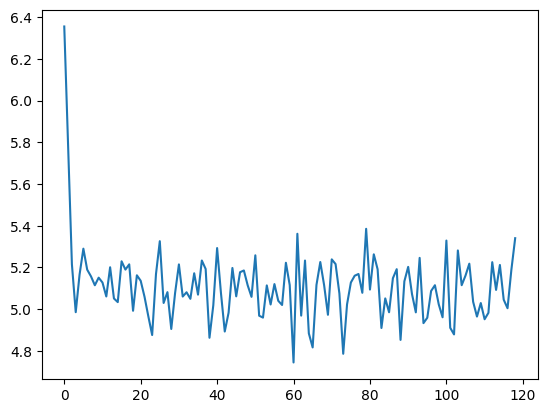

In [12]:
import matplotlib.pyplot as plt

plt.plot(torch.tensor(lossi[: len(lossi) // 6 * 6]).view(-1, 6).mean(dim=-1))
plt.show()

In [13]:
print(model.generate("def"))
# 有点逻辑，但不多。

[BOS] def Pcheuparam ly            c .optionele"""files to num . S
        curbe ' ,
